# Machine Learning in Crowd Modelling and Simulation

In this task we implement a crowd simulation model using the cellular automata approach.
Our implementation can be run either by loading saved scenario files which are based on csv files or by the user detailing their own scenario.

Before moving ahead we import the key packages. It is best to install the required packages as detailed in the
`README.md` file with the help of the provided `requirements.txt` file.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from utilities import parser_array2obj
from visualization import visualize_state
from main import crowd_simulator
%reload_ext autoreload
%autoreload 2
%matplotlib notebook

# Some conventions
Throughout this notebook and in the simulations we will follow some labelling conventions for clarity. These are listen in the table below:

|Numerical Encoding|Description|Color Assignment in GUI and visualizations| |
|---|---|---|---|
|0|Empty Cell| <span style="color:black">Black</span> / <span style="color:blue">Blue</span>.  ||
|1|Pedestrian|  <span style="color:red">Red</span>. | |
|2|Obstacle| <span style="color:yellow">Yellow</span>.  |   |
|3|Target|  <span style="color:green">Green</span>. ||


## Task 1: The setup

It is possible to execute the crowd simulator in two ways. The first is to simply execute the `main.py` file i.e. `python3 main.py` and then following the instructions on the CLI. The second method is to execute it by calling the appropriate function and methods in the jupyter notebook environment. In order to show the functionality of the simulator, we will first make use of the pygame GUI. In subsequent tasks, since we wish to show states and specific plots, we will use the jupyter notebook environment to run the simulations.

Here the user has two options

### Option 1: Load scenario
If you wish to load a scenario then type y in the following cell block. A list of available scenarios will be printed. Enter the id number of the scenario you wish to load and this will be loaded into a variable.


### Option 2: Make customer scenario
If you wish to make own scenario then type n in the following cell block. You will be asked for the size of the grid you wish to generate. Enter the row and column numbers. Finally a GUI will pop up. You can make a scenario there. Type in `P` to add a pedestrian, `O` for object and `T` for target. Please note all of these need to be in **upper case**. If you wish for a cell to remain empty you can leave it as it is. Once you are finished simply close the GUI. The scenario will be saved in a variable for further processing. 


In [70]:
crowd_simulator()

 Leave answers empty for default 
Do you want to load a scenario? (y/n)y
Available scenario files are: 
Scenario 0 :  task_3.csv
Scenario 1 :  chicken_test_multi_peds.csv
Scenario 2 :  chicken_test.csv
Scenario 3 :  multiple_targets.csv
Scenario 4 :  rimea_test1.csv
Scenario 5 :  task_2.csv
Please select which scenario you wish to load. Enter scenario id:0
Initial state of the loaded scenario:
Would you like to use Dijkstra-algorithm? (y/n)n
Maximum number of steps: (Positive integer)40


## Task 2: Single Pedestrian

### The simulation
We will now simulate the loaded scenario with our simple update step i.e. rudementary obstical avoidance and pedestrian repulsion. The scenario is such that we have a grid of 50x50 cells and a pedestrian at position (5,25) and a target at (25,25). Let us see how the pedestrian progresses.

**NOTE: This simulation can also be executed using the pygame GUI. Simply select load scenario and select the task_1.csv scenario file.**
The results will be visualized with the help of a matplotlib animation. The initial state of the scenario is shown below:

<IPython.core.display.Javascript object>


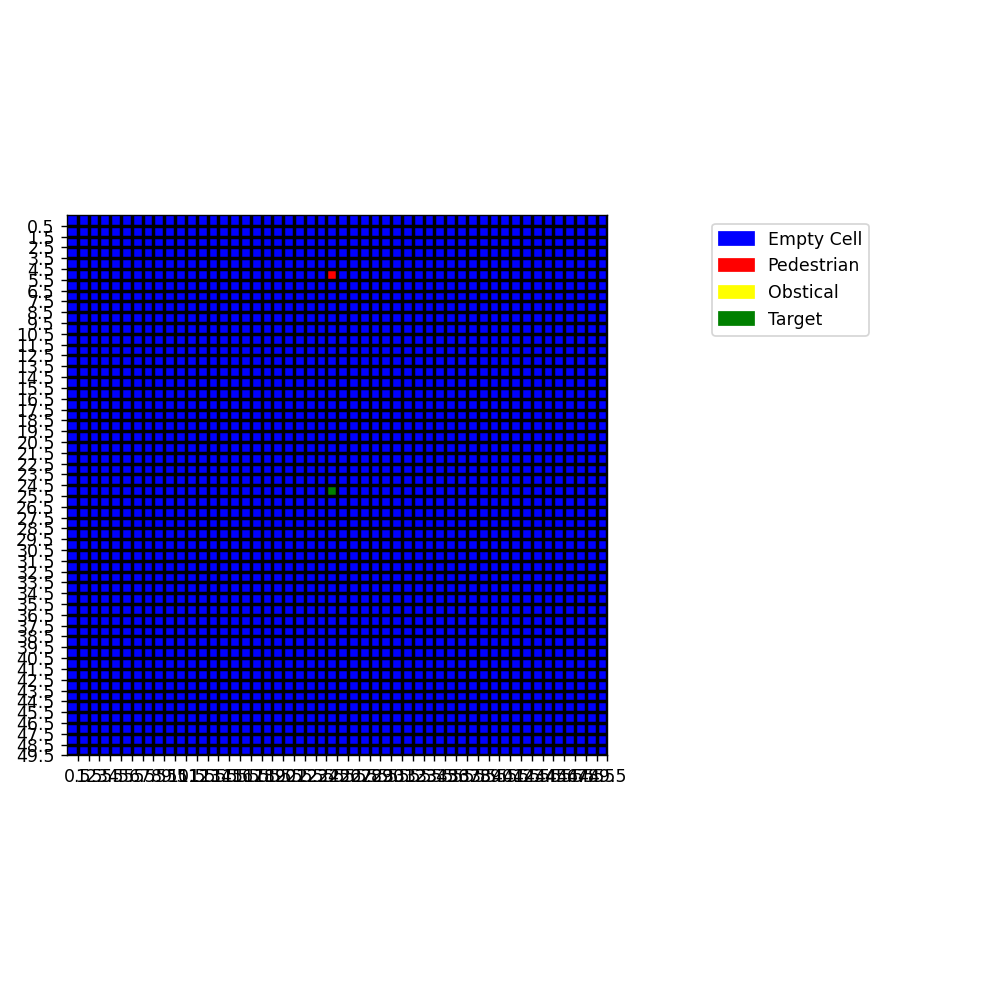

In [61]:
with open('./scenarios/task_2.csv', newline='') as csvfile:
    task_2 = np.array(list(csv.reader(csvfile))).astype(int)
    task_2 = parser_array2obj(task_2)
visualize_state(task_2.to_array())

**Let us simulate this for 25 steps and animate**

<IPython.core.display.Javascript object>


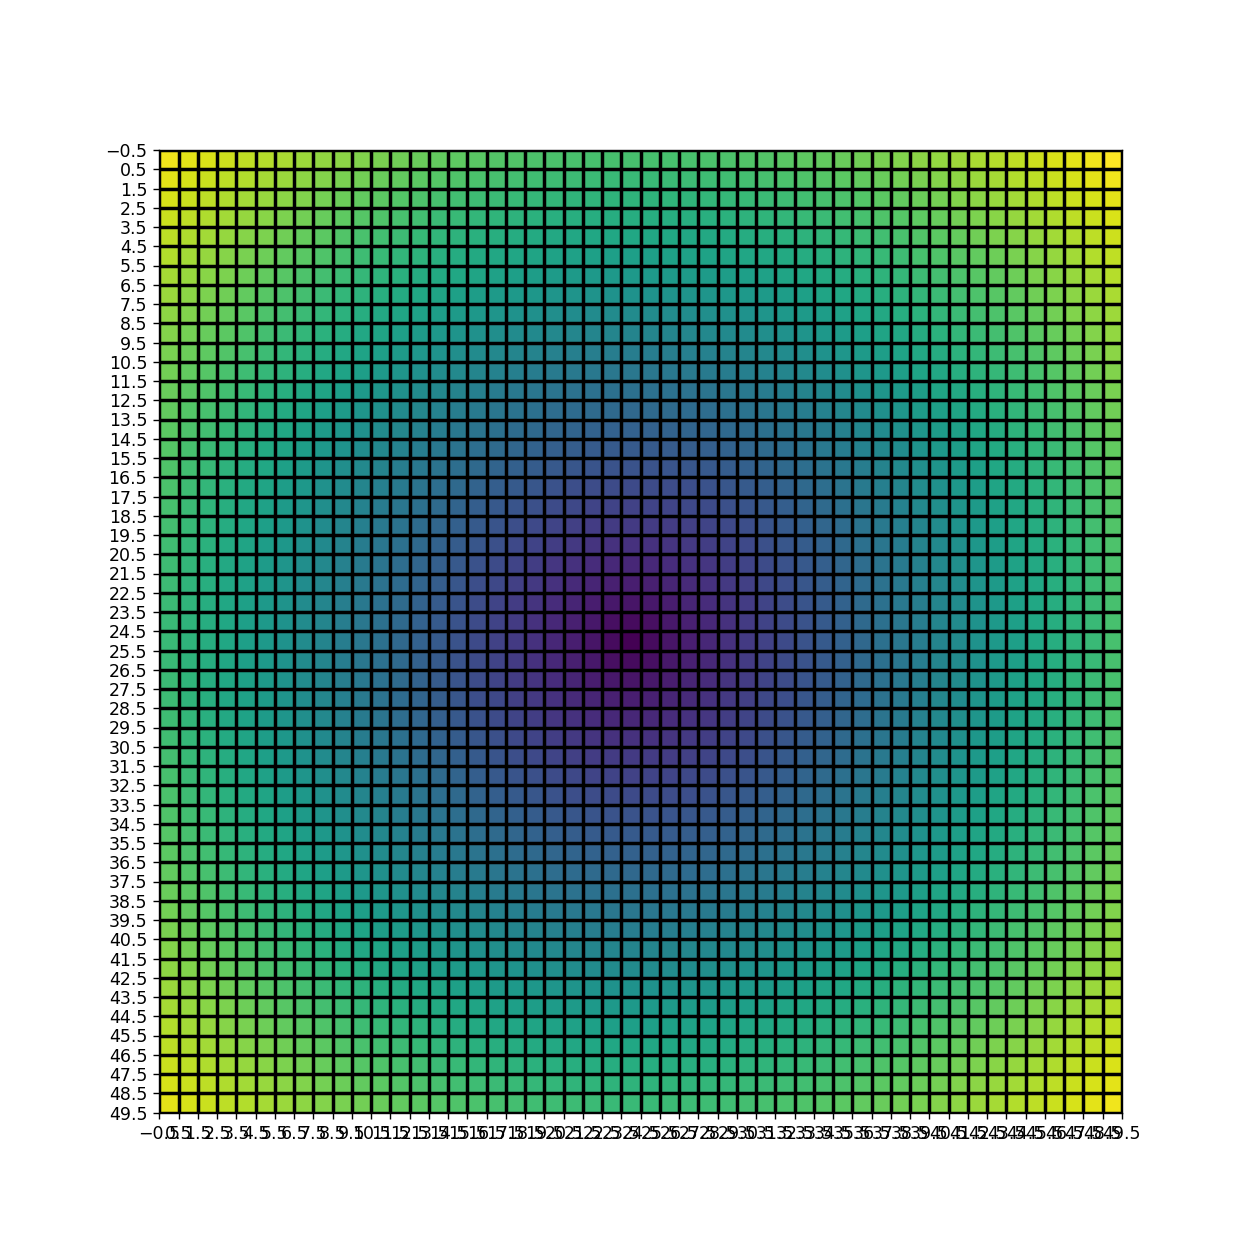

In [64]:
task_2.simulate(25)
task_2.animate()

### Observations

In this simple case, we use the distance of cells to the target as our cost operator for the pedestrian to decide their next move. A visualization of the cost can be seen below:

<IPython.core.display.Javascript object>


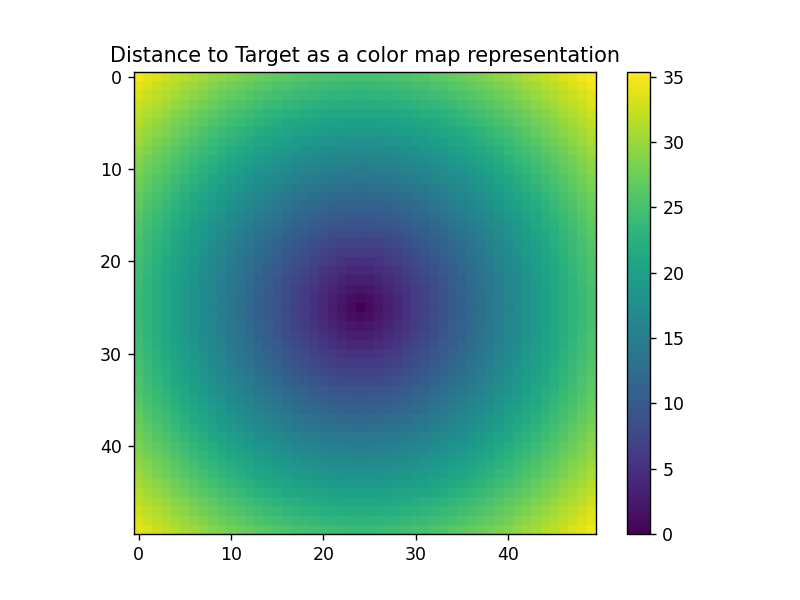

In [62]:
fig = plt.figure()
cost_task_2 = task_2.get_distance_to_target()
plt.imshow(cost_task_2)
plt.colorbar()
plt.title("Distance to Target as a color map representation")
fig.savefig("dist_to_taget_task_2.pdf")

## Task 3: Pedestrian Interaction

In this task we will show how pedestrians interact with each other ina  given scenario.

<IPython.core.display.Javascript object>


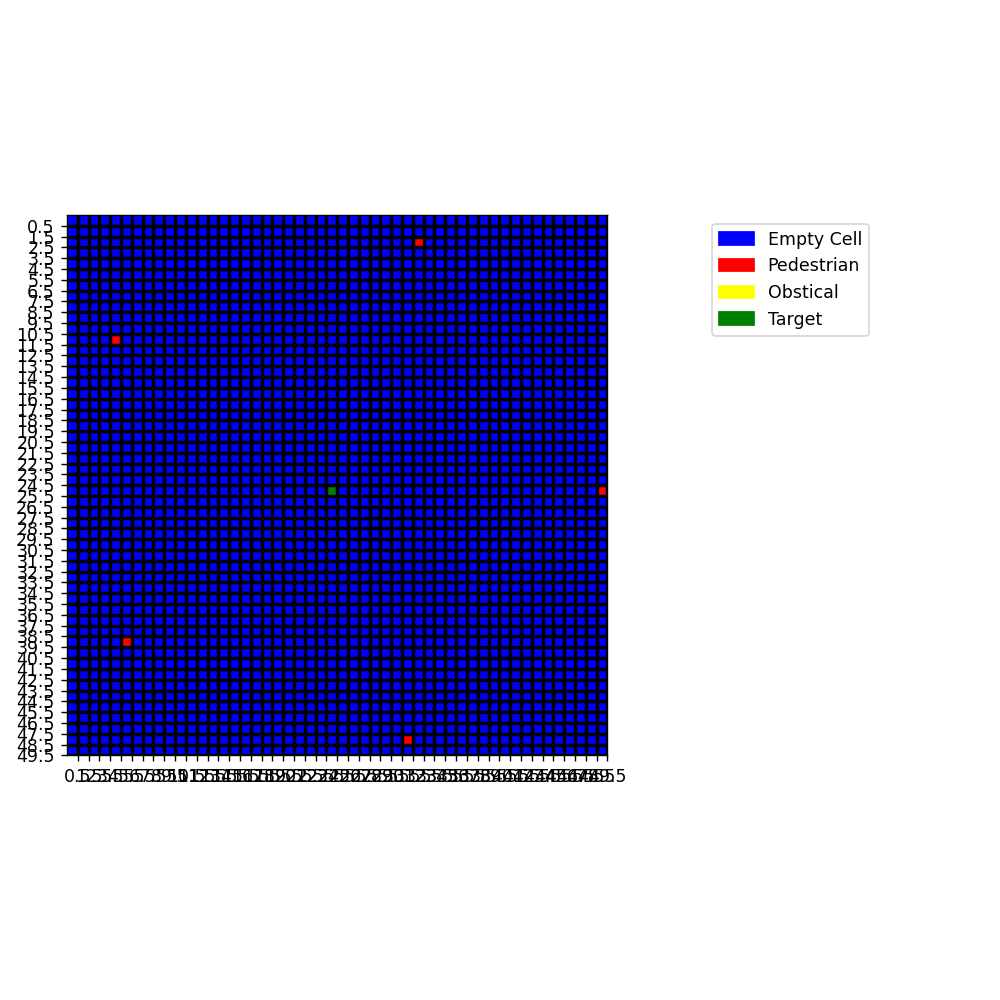

In [63]:
with open('./scenarios/task_3.csv', newline='') as csvfile:
    task_3 = np.array(list(csv.reader(csvfile))).astype(int)
    task_3 = parser_array2obj(task_3)
visualize_state(task_3.to_array())

DONEDONEDONE


<IPython.core.display.Javascript object>


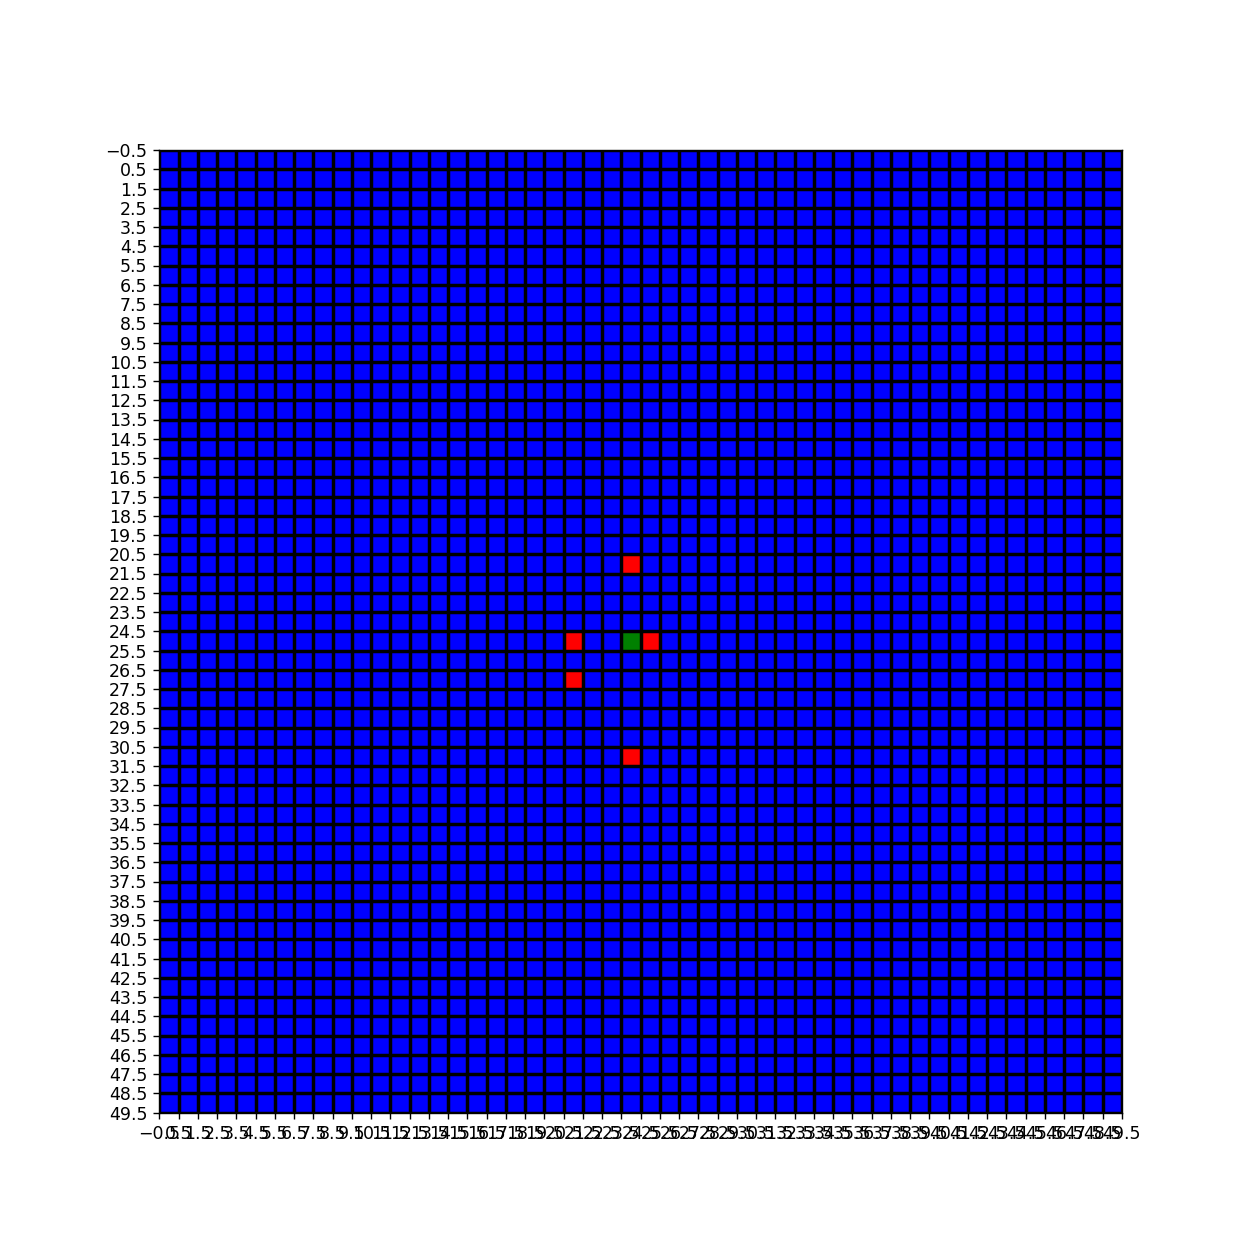

In [57]:
task_3.simulate(50, absorbing_targets=False)
task_3.animate()

## Task 4

### The Dijkstra's Algorithm
We implement the Dijkstra's algorithm to flood the cells with utilitiy values starting from the targets i.e. targets have a cost of 0. 

This allows a kind of look ahead when we simulate our pedestrians since now we have also taken into account the obsticals. Essentially the entire grid is treated as a well connected bi-directional graph instead of the points where the obsticals exist. These cells are treated as unconnected nodes on the graph. This is shown below:

<table>
  <tr>
    <td><img src="./figures/fully_connected.png" width=270 height=480></td>
    <td><img src="./figures/graph_with_obj.png" width=270 height=480></td>
  </tr>
      <tr>
    <td>Fully Connected Bi-Directional Graph</td>
     <td>Bi-directional Graph with Obstacle </td>
  </tr>
 </table>
 
We can show the result of the chicken test with the help of a color map.

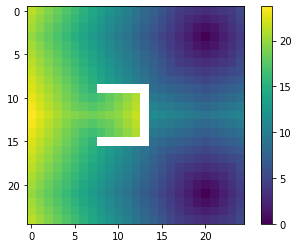

In [4]:
with open('./scenarios/multiple_targets.csv', newline='') as csvfile:
    chicken_test = np.array(list(csv.reader(csvfile))).astype(int)
    chicken_test = parser_array2obj(chicken_test)

fig = plt.figure()
plt.imshow(chicken_test.get_dijkstra())
plt.colorbar()

## Task 5

In [ ]:
### RiMEA 1